In [56]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from scipy.signal.windows import kaiser, hamming

plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42

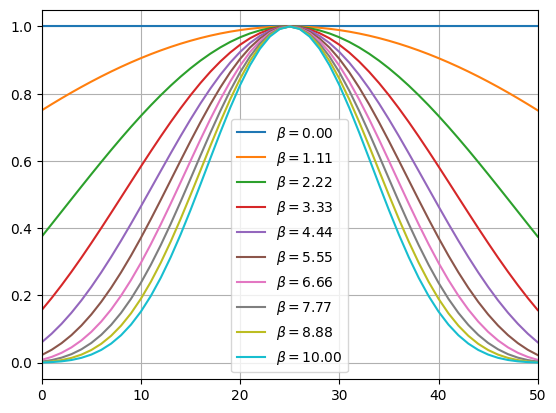

In [57]:
# with plt.style.context(["science", "ieee"]):
plt.figure()

for beta in np.concatenate((np.arange(0, 9, 1.11), [10])):
    plt.plot(kaiser(51, beta), label=f"$\\beta = {beta:.2f}$")

plt.legend()
plt.grid()
plt.xlim(0, 50)

plt.show()

In [67]:
def kernel_signal(signal, points, fs):
    signal = np.asarray(signal) # Converte o sinal de entrada para um array numpy
    factor = 4
    Ts = 1.0 / fs
    t = np.arange(len(signal)) * Ts
    new_len = (len(signal) - 1) * factor + factor # Calcula o novo tamanho do sinal interpolado
    new_signal = np.zeros(new_len)
    t_new = np.linspace(t[0], t[-1], new_len)
    for i in range(new_len):
        main_time = t_new[i]
        soma = 0
        const_norm = 0
        for p in range(-points//2 + 1, points//2 + 1):
            idx = int(np.round((main_time - t[0]) / Ts)) - p
            if 0 <= idx < len(signal):
                sinc_arg = (main_time - t[idx]) / Ts
                const_norm += np.sinc(sinc_arg)
                soma += signal[idx] * np.sinc(sinc_arg)
        new_signal[i] = soma / const_norm if const_norm != 0 else 0
    return new_signal

41


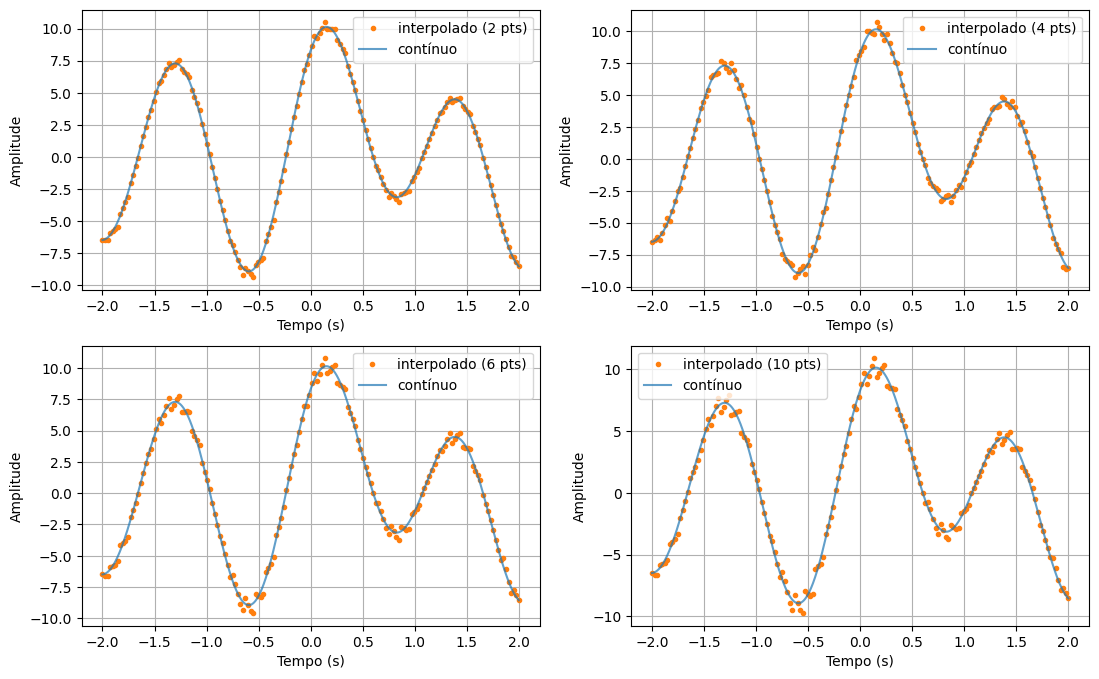

In [68]:
from scipy.fft import fft, fftfreq, fftshift

# Parâmetros
fc = 5         # frequência de corte (Hz)
fs = 2*fc      # frequência de amostragem (Hz)
t_start = -2   # início do tempo (s)
t_end = 2      # fim do tempo (s)
N = int((t_end - t_start) * fs) + 1  # número de amostras para cobrir o intervalo de tempo

# Sinal sinc contínuo
tc = np.linspace(t_start, t_end, 2000)  # tempo contínuo
x_cont = (
    np.sin(fc * tc)
    + 3 * np.cos(fc * tc)
    + tc * np.sin(fc * tc)
    + np.sin(fc / 2 * tc)
    + np.cos(fc / 4 * tc)
    + 2 * np.sin(fc * tc / 1.5)
    + 1.5 * np.cos(fc * tc / 1.2)
    + np.sin(fc * tc / 1.1)
    + np.cos(fc * tc / 1.05)
    + 0.5 * np.sin(fc * tc / 1.01)
    + 0.8 * np.cos(fc * tc)
    + 0.7 * np.sin(fc * tc / 2)
    + 0.6 * np.cos(fc * tc / 3)
    + 0.5 * np.sin(fc * tc / 4)
    + 0.4 * np.cos(fc * tc / 5)
)# Sinal sinc discreto (amostrado)
n = np.arange(N)
center = (N-1)/2
t = (n - center) / fs
x_disc = (
    np.sin(fc * t)
    + 3 * np.cos(fc * t)
    + t * np.sin(fc * t)
    + np.sin(fc / 2 * t)
    + np.cos(fc / 4 * t)
    + 2 * np.sin(fc * t / 1.5)
    + 1.5 * np.cos(fc * t / 1.2)
    + np.sin(fc * t / 1.1)
    + np.cos(fc * t / 1.05)
    + 0.5 * np.sin(fc * t / 1.01)
    + 0.8 * np.cos(fc * t)
    + 0.7 * np.sin(fc * t / 2)
    + 0.6 * np.cos(fc * t / 3)
    + 0.5 * np.sin(fc * t / 4)
    + 0.4 * np.cos(fc * t / 5)
)

print(len(x_disc))
# FFT do sinal discreto
dt = 1.0 / fs
X = fft(x_disc)
X_shifted = fftshift(X)
freqs = fftshift(fftfreq(N, d=dt))

# FFT do sinal contínuo (amostrado finamente)
dtc = tc[1] - tc[0]
XC = fft(x_cont) * dtc
XC_shifted = fftshift(XC)
freqs_cont = fftshift(fftfreq(tc.size, d=dtc))

# Normalização para comparação
scale = np.max(np.abs(XC_shifted))
scale_discrete = np.max(np.abs(X_shifted))
X_plot = np.abs(X_shifted) / scale_discrete
XC_plot = np.abs(XC_shifted) / scale

fig, axs = plt.subplots(2, 2, figsize=(13, 8))
kernel_sizes = [2, 4, 6, 10]  # Adiciona definição para evitar erro
index = 0
# Plota sinais interpolados para diferentes tamanhos de kernel
for pts in kernel_sizes:
    
    x_disc_interp = kernel_signal(x_disc, pts, fs)
    t_interp = np.linspace(t[0], t[-1], len(x_disc_interp))
    axs[index//2,index % 2].plot(t_interp, x_disc_interp, '.',color='C1', label=f'interpolado ({pts} pts)')
    axs[index//2,index % 2].plot(tc, x_cont, '-', color='C0', alpha=0.7, label="contínuo")
    axs[index//2,index % 2].set_xlabel("Tempo (s)")
    axs[index//2,index % 2].set_ylabel("Amplitude")
    axs[index//2,index % 2].grid(True)
    axs[index//2,index % 2].legend()
    index += 1


In [98]:
l = 256  # Length of the image
c = l // 2  # Center of the image
ws = l // 8  # Half of window length

original = np.zeros((l, l))
original[
    c - ws : c + ws,
    c - ws : c + ws,
] = 1

In [91]:
def fft_magnitude(image):
    fft = np.fft.fft2(image)
    fft = np.fft.fftshift(fft)
    return np.abs(fft)

In [62]:
from skimage import exposure

# Função para aumentar o contraste
def enhance_contrast(img):
    img_norm = (img - img.min()) / (img.max() - img.min() + 1e-8)
    return exposure.equalize_adapthist(img_norm, clip_limit=0.06)

In [ ]:
def insert_center_patch(fft_img, patch):
    """
    Insere `patch` no centro de `fft_img` (imagens 2D centradas com fftshift).
    Retorna uma nova imagem de tamanho (H+ph, W+pw) onde os quadrantes originais
    são deslocados para criar espaço central para o patch.
    """
    fft_img = np.asarray(fft_img)
    patch = np.asarray(patch)
    H, W = fft_img.shape
    ph, pw = patch.shape

    newH = H + ph
    newW = W + pw
    out = np.zeros((newH, newW), dtype=fft_img.dtype)

    # divisão em quadrantes (centro em fftshift)
    ch = H // 2
    cw = W // 2
    top_rows = ch
    bot_rows = H - ch
    left_cols = cw
    right_cols = W - cw

    # posiciona quadrantes preservando ordem espacial
    out[0:top_rows, 0:left_cols] = fft_img[0:top_rows, 0:left_cols]                            # TL
    out[0:top_rows, newW - right_cols:newW] = fft_img[0:top_rows, left_cols:W]                  # TR
    out[newH - bot_rows:newH, 0:left_cols] = fft_img[top_rows:H, 0:left_cols]                   # BL
    out[newH - bot_rows:newH, newW - right_cols:newW] = fft_img[top_rows:H, left_cols:W]        # BR

    # insere o patch no centro (espaço criado entre os quadrantes)
    row0 = top_rows
    col0 = left_cols
    out[row0:row0 + ph, col0:col0 + pw] = patch

    return out


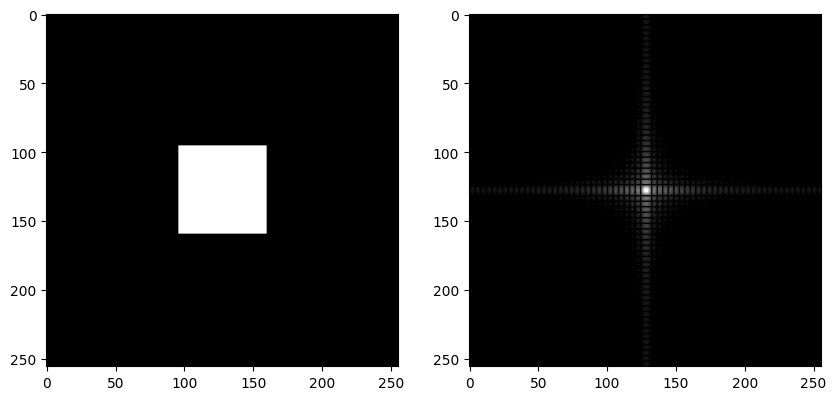

In [99]:
fig, axs = plt.subplots(1, 2, figsize=(10, 20))
axs = axs.flatten()


fft_image = enhance_contrast(fft_magnitude(original))

axs[0].imshow(original, cmap="gray")
axs[1].imshow(fft_image, cmap="gray")


In [ ]:
def IFFT(image):
    ifft = np.fft.ifft2(image)
    ifft = np.fft.ifftshift(ifft)
    return np.abs(ifft)

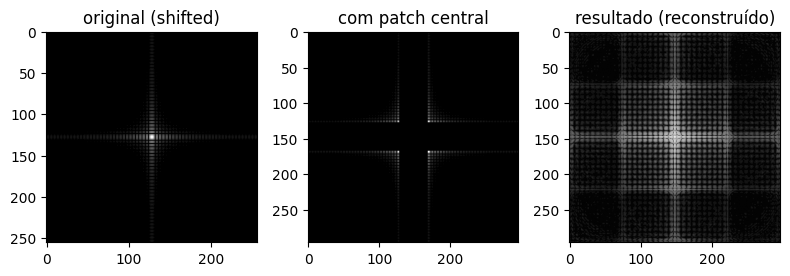

In [100]:
patch = np.zeros((40, 40)) * 5.0  
out = insert_center_patch(fft_image, patch)

result_image = IFFT(out)

plt.figure(figsize=(8,8))
plt.subplot(1,3,1); plt.imshow(fft_image, cmap='gray'); plt.title('original (shifted)')
plt.subplot(1,3,2); plt.imshow(out, cmap='gray'); plt.title('com patch central')
plt.subplot(1,3,3); plt.imshow(enhance_contrast(result_image), cmap='gray'); plt.title('resultado (reconstruído)')
plt.tight_layout()
plt.show()